# Computer Vision

## Lab 4

### Imports

In [460]:
# Computation
import numpy as np
import cv2
from skimage import color, feature

# Plotting
import matplotlib.pyplot as plt

In [461]:
image = np.array(cv2.imread("./image-83.jpg")[:,:,::-1], dtype=np.float32) / 255
image_gray = color.rgb2gray(image)

image_small = cv2.resize(image_gray, (640, 480))
image_xsmall = cv2.resize(image_gray, (256, 192))

mask = np.array(cv2.imread("./mask-83.png")[:,:,::-1], dtype=np.float32) / 255
mask_gray = color.rgb2gray(mask)

mask_small = cv2.resize(mask_gray, (640, 480))
mask_xsmall = cv2.resize(mask_gray, (256, 192))

### Section 1 - Canny Edge Detector

#### Question 1

In [462]:

truncate = 4.0

def canny_edge_detector(image, sigma, low_threshold, high_threshold, plot_steps = False):
    height, width = image.shape

    # 1. Apply gaussian filter
    size = np.uint8(2 * (np.floor(truncate * sigma + 0.5)) + 1)
    gaussian_image = cv2.GaussianBlur(image, ksize=(
        size, size), sigmaX=sigma, borderType=cv2.BORDER_REPLICATE)


    # 2. Gradient magnitude and direction
    Gx = cv2.Sobel(gaussian_image, -1, 1, 0, ksize=3,
                   borderType=cv2.BORDER_REFLECT)
    Gy = cv2.Sobel(gaussian_image, -1, 0, 1, ksize=3,
                   borderType=cv2.BORDER_REFLECT)

    G = np.hypot(Gx, Gy)
    G = G / G.max()  # Normalize

    theta = np.arctan2(Gy, Gx)
    theta[theta < 0] += np.pi  # Range [0, pi]

    # 3. Non-maximal suppression
    def non_maximal_suppression(_G, _theta):
        height, width = _G.shape
        NMS = np.zeros((height, width))
        eighth = np.pi / 8

        for y in range(height):
            for x in range(width):
                angle = _theta[y, x]
                p1, p2 = 0, 0

                def inbound_get(y_shift=0, x_shift=0):
                    if 0 <= y+y_shift <= height-1 and 0 <= x+x_shift <= width-1:
                        return _G[y+y_shift, x+x_shift]
                    return _G[y, x]

                # 0°(0)[ + 180°(np.pi)] ± 22.5°(np.pi/8)
                if angle < (0 + eighth) or angle >= (np.pi - eighth):
                    p1 = inbound_get(0, -1)
                    p2 = inbound_get(0, 1)

                # 45°(np.pi/4)[ + 180°] ± 22.5°
                elif (np.pi/4 - eighth) <= angle < (np.pi/4 + eighth):
                    p1 = inbound_get(-1, 1)
                    p2 = inbound_get(1, -1)

                # 90°(np.pi/2)[ + 180°] ± 22.5°
                elif (np.pi/2 - eighth) <= angle < (np.pi/2 + eighth):
                    p1 = inbound_get(-1, 0)
                    p2 = inbound_get(1, 0)

                # 135°(np.pi*3/4)[ + 180°] ± 22.5°
                elif (np.pi * 3/4 - eighth) <= angle < (np.pi * 3/4 + eighth):
                    p1 = inbound_get(-1, -1)
                    p2 = inbound_get(1, 1)

                if (_G[y, x] >= p1) and (_G[y, x] >= p2):
                    NMS[y, x] = _G[y, x]

        return NMS

    NMS = non_maximal_suppression(G, theta)

    # 4. Double thresholding
    T = np.zeros(NMS.shape)
    T[NMS >= low_threshold] = 0.5
    T[NMS > high_threshold] = 1.0

    # 5. Hysteresis
    def hysteresis(_T):
        height, width = _T.shape

        asc_y = range(height)
        desc_y = range(height-1, -1, -1)
        asc_x = range(width)
        desc_x = range(width-1, -1, -1)
        
        radius = 1

        # Scan from top-left, top-right, bottom-left and bottom-right
        ranges = [(asc_y, asc_x), (asc_y, desc_x), (desc_y, asc_x), (desc_y, desc_x)]
        for range_y, range_x in ranges:
            for y in range_y:
                for x in range_x:
                    if _T[y, x] == 0.0 or _T[y, x] == 1.0:
                        continue

                    min_y = np.max([y-radius, 0])
                    max_y = np.min([y+radius, height-1])
                    min_x = np.max([x-radius, 0])
                    max_x = np.min([x+radius, width-1])

                    if 1.0 in _T[min_y:max_y+1, min_x:max_x+1]:
                        _T[y, x] = 1.0

        # Set anything else to 0
        _T[_T < 1.0] = 0.0

        return _T

    H = hysteresis(T)
    
    if plot_steps:
        fig = plt.figure(figsize=(width * 8/96, height/96))

        fig.add_subplot(1, 8, 1)
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('gray')
        
        fig.add_subplot(1, 8, 2)
        plt.imshow(gaussian_image, cmap="gray")
        plt.axis('off')
        plt.title(f'gaussian (size={size})')

        fig.add_subplot(1, 8, 3)
        plt.imshow(Gx, cmap="gray")
        plt.axis('off')
        plt.title('Gx')

        fig.add_subplot(1, 8, 4)
        plt.imshow(Gy, cmap="gray")
        plt.axis('off')
        plt.title('Gy')
        
        fig.add_subplot(1, 8, 5)
        plt.imshow(G, cmap="gray")
        plt.axis('off')
        plt.title('G')

        fig.add_subplot(1, 8, 6)
        plt.imshow(NMS, cmap="gray")
        plt.axis('off')
        plt.title('Non-maximal suppression')

        fig.add_subplot(1, 8, 7)
        plt.imshow(T, cmap="gray")
        plt.axis('off')
        plt.title('Thresholding')

        fig.add_subplot(1, 8, 8)
        plt.imshow(H, cmap="gray")
        plt.axis('off')
        plt.title('Hysteresis')

        fig.savefig('./canny_steps.png')

    return H


#### Question 2

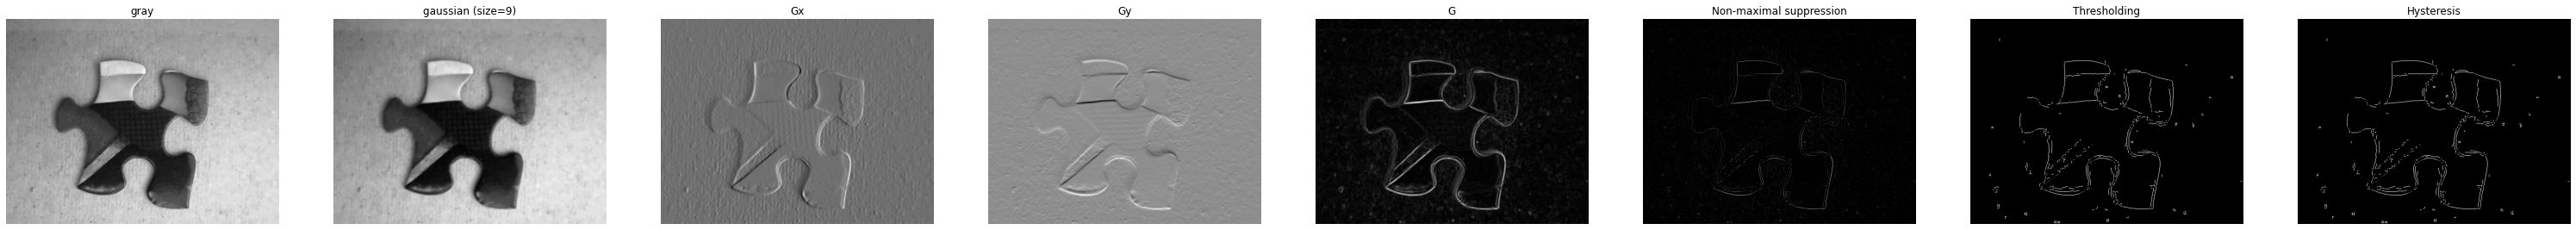

In [463]:
sigma = 1
low_threshold = 0.1
high_threshold = 0.2

_ = canny_edge_detector(image_small, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, plot_steps=True)

#### Question 3

Text(0.5, 1.0, 'skimage canny (default params)')

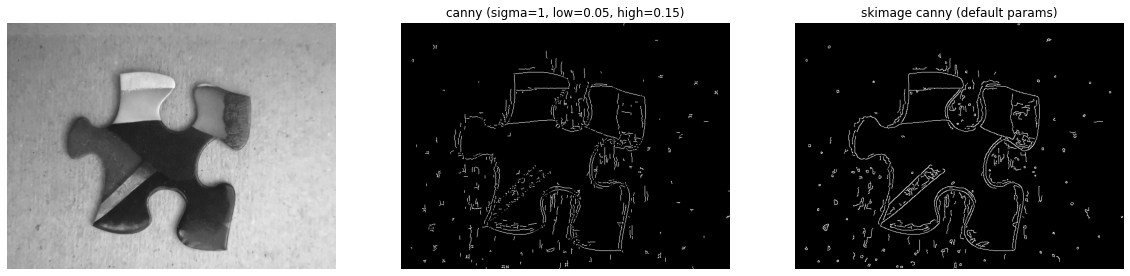

In [464]:
sigma = 1
low_threshold = 0.05
high_threshold = 0.15

canny_image = canny_edge_detector(image_small, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

lib_canny = feature.canny(image_small)

fig = plt.figure(figsize=(20, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(image_gray, cmap="gray")
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(canny_image, cmap="gray")
plt.axis('off')
plt.title(f'canny (sigma={sigma}, low={low_threshold}, high={high_threshold})')

fig.add_subplot(1, 3, 3)
plt.imshow(lib_canny, cmap="gray")
plt.axis('off')
plt.title('skimage canny (default params)')

#### Question 4

Text(0.5, 1.0, 'canny (high_threshold=0.5)')

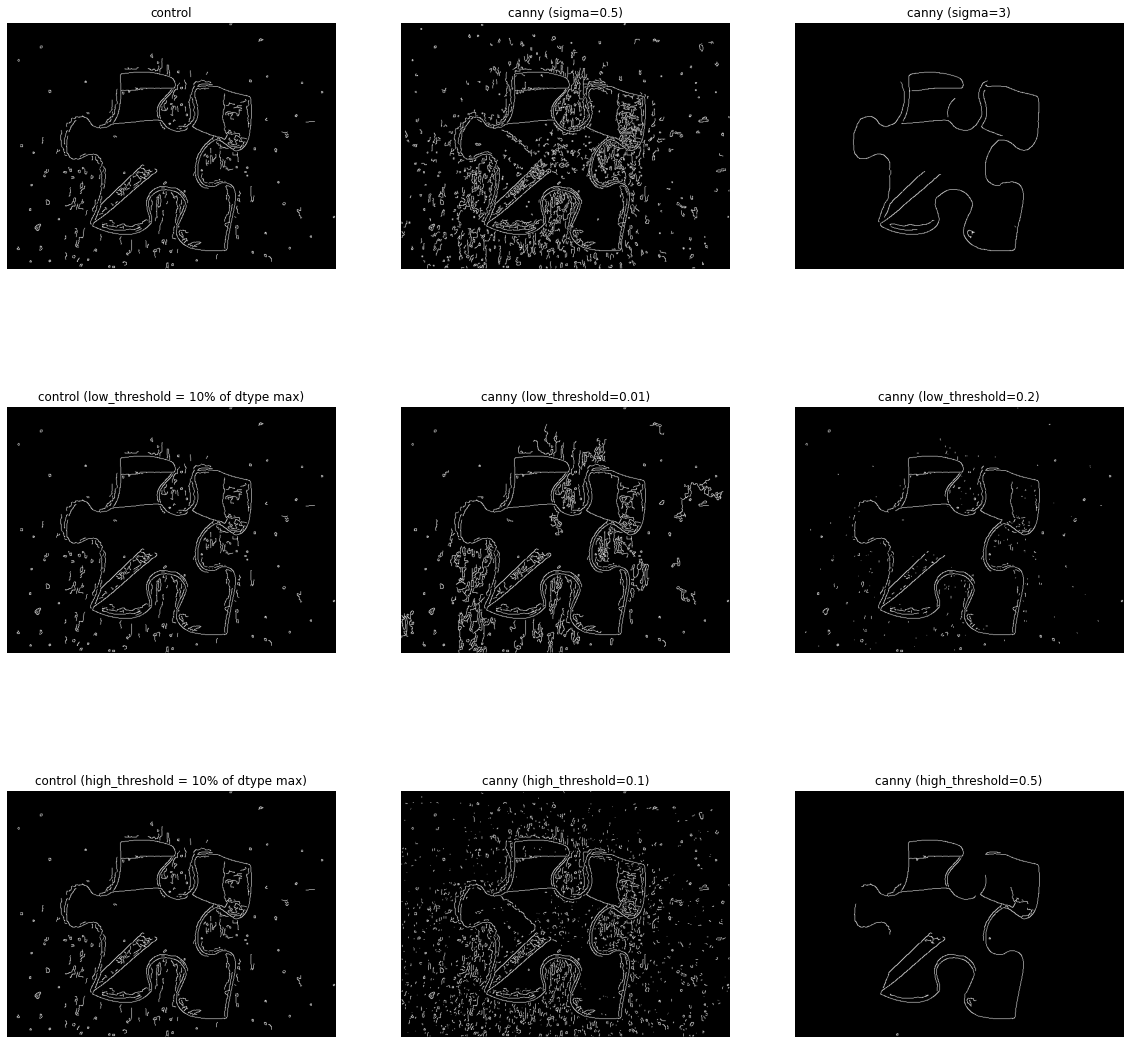

In [465]:
canny_control = feature.canny(image_small)

low_sigma = 0.5
canny_low_sigma = feature.canny(image_small, sigma = low_sigma)

high_sigma = 3
canny_high_sigma = feature.canny(image_small, sigma = high_sigma)

very_low_low_t = 0.01
canny_very_low_low_t = feature.canny(image_small, low_threshold = very_low_low_t)

high_low_t = 0.2
canny_high_low_t = feature.canny(image_small, low_threshold = high_low_t)

low_high_t = 0.1
canny_low_high_t = feature.canny(image_small, high_threshold = low_high_t)

very_high_high_t = 0.5
canny_very_high_high_t = feature.canny(image_small, high_threshold = very_high_high_t)


fig = plt.figure(figsize=(20, 20))

fig.add_subplot(3, 3, 1)
plt.imshow(canny_control, cmap="gray")
plt.axis('off')
plt.title('control')

fig.add_subplot(3, 3, 2)
plt.imshow(canny_low_sigma, cmap="gray")
plt.axis('off')
plt.title(f'canny (sigma={low_sigma})')

fig.add_subplot(3, 3, 3)
plt.imshow(canny_high_sigma, cmap="gray")
plt.axis('off')
plt.title(f'canny (sigma={high_sigma})')

fig.add_subplot(3, 3, 4)
plt.imshow(canny_control, cmap="gray")
plt.axis('off')
plt.title('control (low_threshold = 10% of dtype max)')

fig.add_subplot(3, 3, 5)
plt.imshow(canny_very_low_low_t, cmap="gray")
plt.axis('off')
plt.title(f'canny (low_threshold={very_low_low_t})')

fig.add_subplot(3, 3, 6)
plt.imshow(canny_high_low_t, cmap="gray")
plt.axis('off')
plt.title(f'canny (low_threshold={high_low_t})')

fig.add_subplot(3, 3, 7)
plt.imshow(canny_control, cmap="gray")
plt.axis('off')
plt.title('control (high_threshold = 10% of dtype max)')

fig.add_subplot(3, 3, 8)
plt.imshow(canny_low_high_t, cmap="gray")
plt.axis('off')
plt.title(f'canny (high_threshold={low_high_t})')

fig.add_subplot(3, 3, 9)
plt.imshow(canny_very_high_high_t, cmap="gray")
plt.axis('off')
plt.title(f'canny (high_threshold={very_high_high_t})')

#### Question 5

Text(0.5, 1.0, 'canny (sigma=3, low=0.05, high=0.2)')

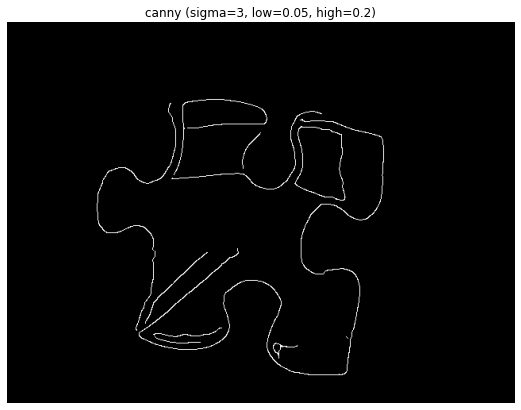

In [466]:
sigma = 3
low_threshold = 0.05
high_threshold = 0.2

canny_results = feature.canny(image_small, sigma = sigma, low_threshold = low_threshold, high_threshold = high_threshold)

fig = plt.figure(figsize=(20, 20))

fig.add_subplot(1, 2, 2)
plt.imshow(canny_results, cmap="gray")
plt.axis('off')
plt.title(f'canny (sigma={sigma}, low={low_threshold}, high={high_threshold})')

### Section 2 - Harris Corner Detector

#### Question 1

In [535]:
def get_gaussian_kernel(size, sigma):
    D = int((size-1) / 2)
    gaussian = np.zeros((size, size))
    gaussian[D, D] = 1
    return cv2.GaussianBlur(gaussian, ksize=(size, size), sigmaX=sigma)

def harris(image, sigma, K, T, plot_steps = False):
    height, width = image.shape
    size = int(2 * (np.floor(truncate * sigma + 0.5)) + 1)
    D = int((size - 1) / 2)
    
    # 1. Sobel Gradients
    Gh = cv2.Sobel(image, -1, 1, 0, ksize=3,
                   borderType=cv2.BORDER_CONSTANT)
    Gv = cv2.Sobel(image, -1, 0, 1, ksize=3,
                   borderType=cv2.BORDER_CONSTANT)
    
    # 2. Image Structure Tensor
    ## Pad gradients
    Gh_pad = np.pad(Gh, pad_width=D, constant_values=0)
    Gv_pad = np.pad(Gv, pad_width=D, constant_values=0)
    
    
    ## Weighted sliding window (by gaussian kernel)
    gaussian_kernel = get_gaussian_kernel(size, sigma)
    Gh_win = np.lib.stride_tricks.sliding_window_view(Gh_pad, window_shape=(size, size)) * gaussian_kernel
    Gv_win = np.lib.stride_tricks.sliding_window_view(Gv_pad, window_shape=(size, size)) * gaussian_kernel
    
    ## Sum windows
    A = np.sum(Gh_win ** 2, axis=(2,3))
    B = np.sum(Gh_win * Gv_win, axis=(2,3))
    C = np.sum(Gv_win ** 2, axis=(2,3))
    
    # 3. Harris response
    R = (A * C - (B ** 2)) - K * ((A + C) ** 2)
    
    # 4. Remove spurious corners
    R_no_spurious = R.copy()
    R_pad = np.pad(R_no_spurious, pad_width=1, constant_values=0)
    R_windows = np.lib.stride_tricks.sliding_window_view(R_pad, window_shape=(3, 3))
    non_maxima_pos = R_windows[:, :, 1, 1] != np.max(R_windows, axis=(2,3))
    R_no_spurious[non_maxima_pos] = 0
    
    # 5. Thresholding
    R_threshold = np.argwhere(R_no_spurious > T * np.max(R_no_spurious))
    
    if plot_steps:
        fig = plt.figure(figsize=(width * 4/96, height * 3/96))

        fig.add_subplot(3, 4, 1)
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('gray')

        fig.add_subplot(3, 4, 2)
        plt.imshow(Gh, cmap="gray")
        plt.axis('off')
        plt.title('Gh')

        fig.add_subplot(3, 4, 3)
        plt.imshow(Gv, cmap="gray")
        plt.axis('off')
        plt.title('Gv')

        fig.add_subplot(3, 4, 4)
        plt.scatter(x=Gh.flatten(), y=Gv.flatten(), color=(1,0,0), s=4)
        plt.title('Gradients')

        fig.add_subplot(3, 4, 5)
        plt.imshow(A, cmap="gray")
        plt.axis('off')
        plt.title('A')

        fig.add_subplot(3, 4, 6)
        plt.imshow(B, cmap="gray")
        plt.axis('off')
        plt.title('B')

        fig.add_subplot(3, 4, 7)
        plt.imshow(C, cmap="gray")
        plt.axis('off')
        plt.title('C')

        fig.add_subplot(3, 4, 8)
        plt.imshow(R, cmap="gray")
        plt.axis('off')
        plt.title('R')

        fig.add_subplot(3, 4, 9)
        plt.imshow(R_no_spurious, cmap="gray")
        plt.axis('off')
        plt.title('R (no spurious)')

        fig.add_subplot(3, 4, 10)
        plt.table(cellText=R_threshold, colLabels=['y', 'x'], loc='center', cellLoc='center')
        plt.axis('off')
        plt.title('Corner coordinates')
        
        fig.add_subplot(3, 4, 11)
        plt.scatter(R_threshold.T[1], R_threshold.T[0], color=(0,1,0))
        plt.imshow(image, cmap="gray")
        plt.title('Corners overlaid')
        
        fig.savefig('./harris_corner_steps.png')
           
    return R_threshold

#### Question 2

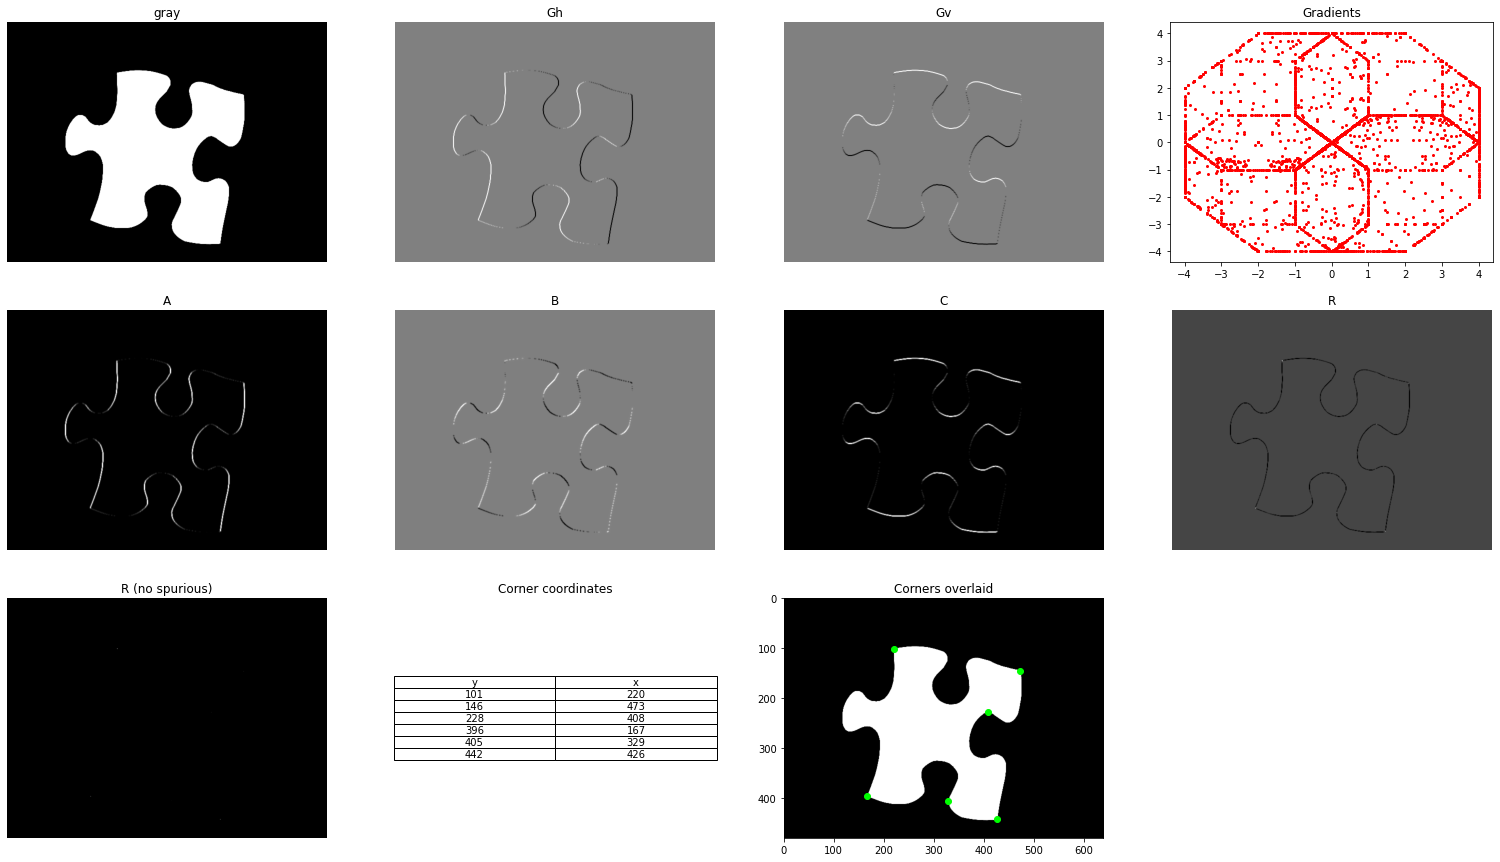

In [536]:
sigma = 1
K = 0.05
T = 0.05
harris_corners = harris(mask_small, sigma=sigma, K=K, T=T)

In [526]:
def apply_corners(image, corners):
    for corner in corners:
        image = cv2.circle(image, (corner[1], corner[0]), radius=12, color=(0,1,0), thickness=2)
    return image

(-0.5, 639.5, 479.5, -0.5)

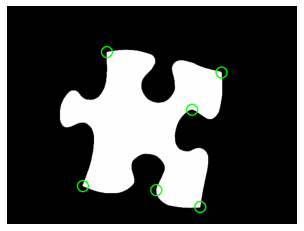

In [528]:
corner_image = apply_corners(color.gray2rgb(mask_small), harris_corners)
plt.imshow(corner_image)
plt.axis('off')

#### Question 3

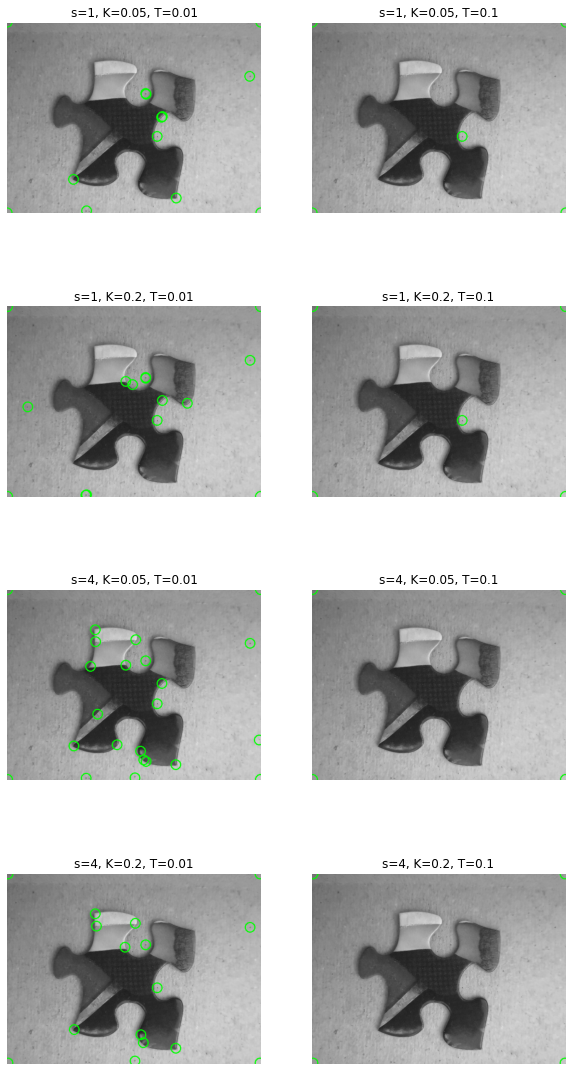

In [534]:
#sigmas = [1, 2, 4, 8]
sigmas = [1, 4]
sigma_size = len(sigmas)

# Ks = [0.025, 0.05, 0.1, 0.2]
Ks = [0.05, 0.2]
K_size = len(Ks)

# Ts = [0.01, 0.05, 0.1, 0.2]
Ts = [0.01, 0.1]
T_size = len(Ts)

fig = plt.figure(figsize=(5 * T_size, 5*sigma_size * K_size))

for i, sigma in enumerate(sigmas):
    for j, K in enumerate(Ks):
        for k, T in enumerate(Ts):
            corners = harris(image_small, sigma=sigma, K=K, T=T)
            overlaid_image = apply_corners(color.gray2rgb(image_small), corners)
            
            index = i * (K_size * T_size) + j * K_size + k + 1
            
            fig.add_subplot(sigma_size * K_size, T_size, index)
            plt.imshow(overlaid_image)
            plt.axis('off')
            plt.title(f's={sigma}, K={K}, T={T}')

### Section 3 - HOG (Histogram of Oriented Gradients) Descriptor